# Exploring AFSK in Python
### Written by David K. Olson, K7ARX

The AX.25 protocol is actually pretty simple, but figuring out how to implement it from scratch took a lot of research, reverse engineering, and asking questions. This notebook explains what I've been able to learn and builds a Python framework for encoding data in a proper AX.25 packet.

For reference, the key web page that unlocked the last critical items I needed to understand is found at http://n1vg.net/packet/. 

A very useful tool (for linux) and its source code that I used in reverse engineering: https://github.com/wb2osz/direwolf

In [1]:
### Useful modules, configuration for this notebook.

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.size']=14

## Decoding data from audio

As an example, I'll use the audio file used as an example of an APRS packet on Wikipedia (https://en.wikipedia.org/wiki/File:AFSK_1200_baud.ogg). The soundfile module lets us import this into a numpy array directly.

In [2]:
import soundfile as sf
raw_signal, raw_rate = sf.read('AFSK_1200_baud.ogg')
print(len(raw_signal),raw_rate)

38816 44100


This audio is sampled at 44.1 kHz and is just short of 1 s long. 44.1 kHz, unfortunately, is not a multiple of 1200 baud, so resampling the audio to 48 kHz will make analysis more convenient. Because the audio signal is well below the Nyquist frequency (half the sampling rate, or 22 kHz in this case), upsampling from 44.1 to 48 kHz will not introduce artifacts to the signal integrity. Alternatively, we could downsample to 43.2 kHz.

*Note: we will see shortly that this decision does introduce one problem that's easily dealt with.*

In [3]:
raw_time = np.arange(0,len(raw_signal)/raw_rate,1/raw_rate)   # Create the time base for the raw signal
rate = 48000
time = np.arange(0,raw_time[-1],1/rate)    # Create the time base for the upsampled signal

signal = np.interp(time,raw_time,raw_signal)    # Numpy's interp function returns a simple, linearly interpolated array

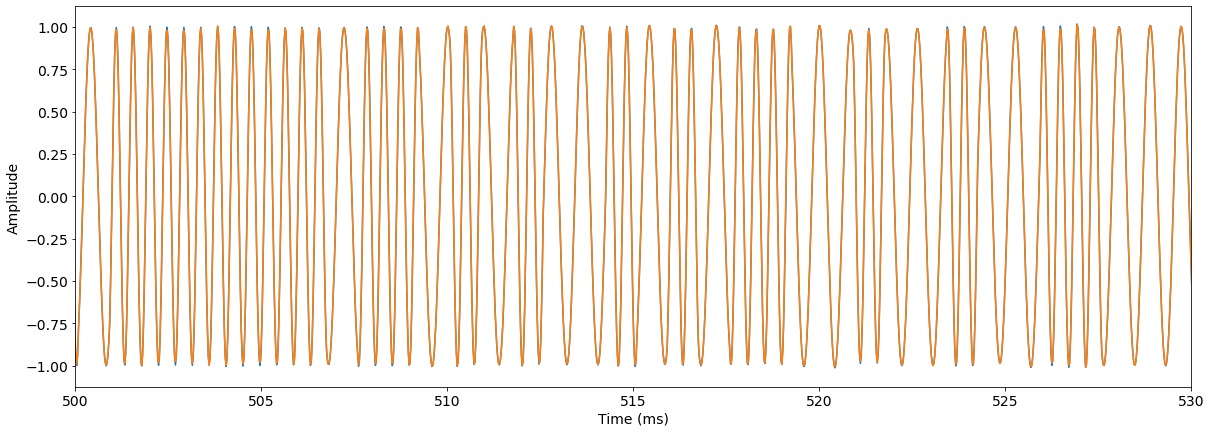

In [4]:
plt.figure(figsize=(20,7))
plt.plot(raw_time*1000,raw_signal)    # x1000 to convert time to milliseconds
plt.plot(time*1000,signal)
plt.xlim(500,530)
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude");

The data portion of the packet starts a little over 0.5 seconds into the recording. Looking at a plot of the waveform, you can clearly see the difference between the two audio frequencies used in the encoding (1200 Hz and 2200 Hz).

Each bit of data is transmitted at 1200 baud (bits per second). Since we upsampled the audio to 48 kHz, that means each bit is exactly 40 samples long. We need to identify whether there's any offset we need to account for in the recording so we can split the waveform into individual bits.

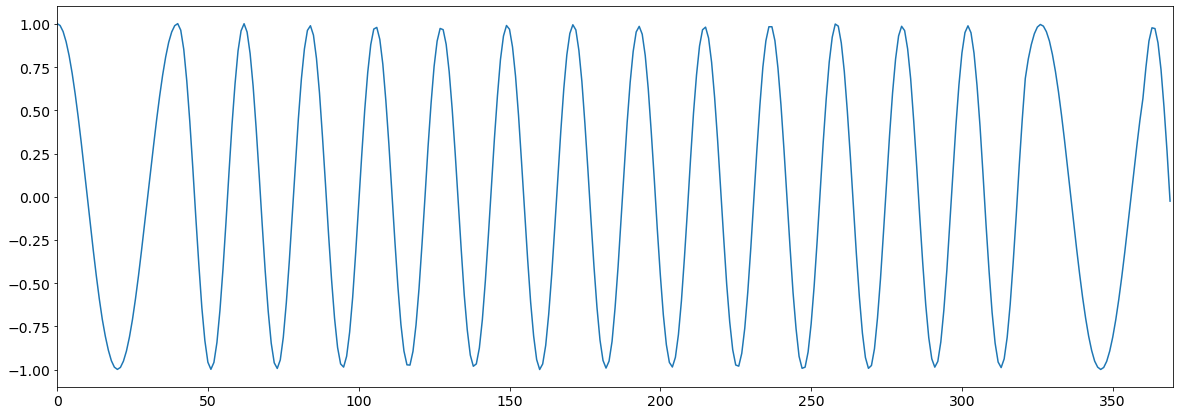

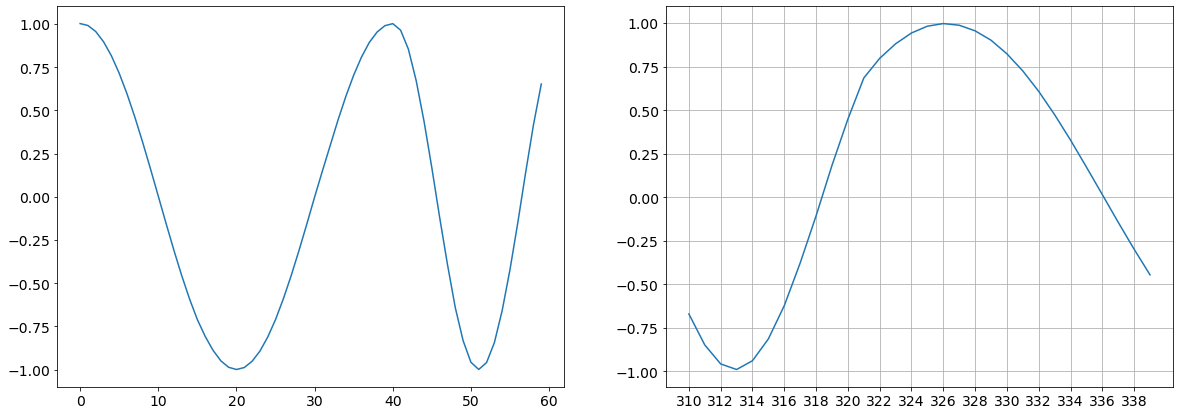

In [5]:
plt.figure(figsize=(20,7))
plt.plot(signal[:370])
plt.xlim(0,370)
fig,ax = plt.subplots(1,2,figsize=(20,7))
ax[0].plot(signal[:60])
ax[1].plot(range(310,340),signal[310:340])
ax[1].set_xticks(range(310,340,2))
ax[1].grid();

Zooming in to the first byte or so of data, we note that it's difficult to determine where the transition between 1200 Hz and 2200 Hz occurs. In the second plot (looking at the next time 1200 Hz appears), there is a clear break between the two bits at index 321. We'll use this second 1200 Hz segment as the start of our data to decode. Since the actual data doesn't start until well into the audio, we're not losing anything helpful by cutting off the beginning portion.

Looking ahead, you'll see that the transition on the first segment occurs at index 41; that makes the width of the first segment 41 wide rather than 40 wide. (Alternatively, we could just throw out the first index of this particular array entirely and have the entire clip be synchronized. This problem is most likely a result of the upsampling I did earlier.) In general, you should always examine your audio sample for noise, distortion, etc at the start that you need to cut in order to get good results.

*Note: It's very likely that if we has just divided up the signal into 40 sample segments from the start, we'd still extract the correct data using the method I employ below. In fact, there's more than likely other places in the upsampled data where a segment should technically be 41 samples wide. But in a general audio recording, the audio will not necessarily start at index 0 as it does here, so this method is demonstrated as it will be most likely needed in the general case.*

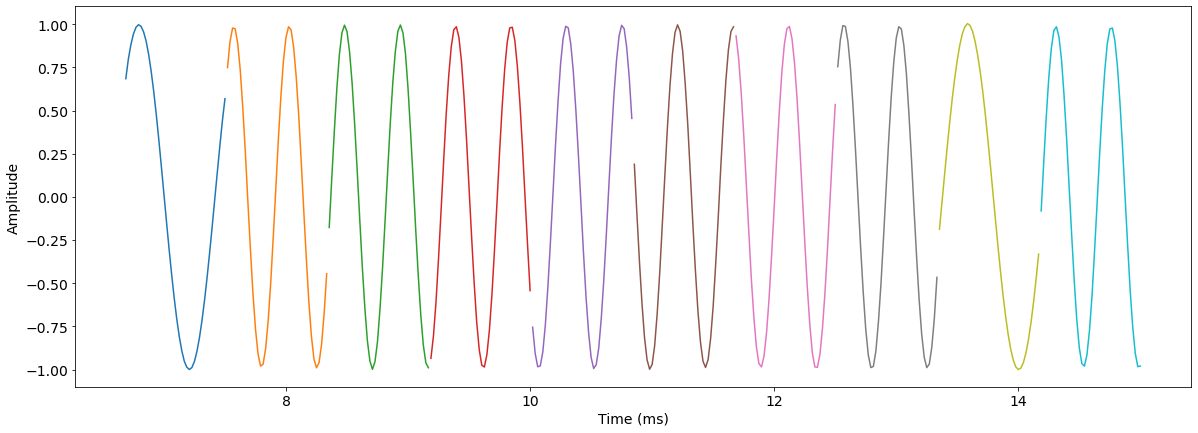

In [6]:
offset = 321
symbol_width = 40

plt.figure(figsize=(20,7))
for i in range(10):
    plt.plot(time[i*symbol_width+offset:(i+1)*symbol_width+offset]*1000,signal[i*symbol_width+offset:(i+1)*symbol_width+offset])
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude");

Here we can see each individual symbol (just the first 10). Note that there are no slope breaks like we saw above. (The gaps between symbols comes from each symbol not sharing its endpoints with its neighboring symbols.)

Next we need to identify the tones in each symbol. ***Note: the tone does not provide the logic value of the data.*** More on that later. For now, let's identify each symbol as 'L' for 1200 Hz and 'H' for 2200 Hz. We could determine which tone is used in the symbol in a variety of ways. Here, I'm going to do it by comparing the amount of time between the first peak and the first trough. Because our low tone is the same frequency as our symbol rate, we could have a situation where either the peak or the trough is not locatable (this would happen when the symbol starts at a phase corresponding to exactly the peak or trough). We'll add to our algorithm logic so that if it can't find a peak or can't find a trough, it defaults to 'L'.

With 40 samples per symbol, the distance between a peak and trough at 1200 Hz will be about 20 samples. For 2200 Hz, the distance will be about 10 or 11 samples depending on phasing. If we set the threshold to a value between 11 and 20, we should be able to tell the difference between the tones.

In [7]:
from scipy.signal import find_peaks

def check_tone(data,thresh=15):
    p = find_peaks(data)[0]
    v = find_peaks(-1*data)[0]
    if len(p)>0 and len(v)>0: 
        tone = {0:'H', 1:'L'}[int(abs(p[0]-v[0])>thresh)]   # If the half-period is more than 15, interpret as a 1200 Hz tone. Otherwise, interpret as 2200 Hz.
    else: 
        tone = 'L'    # default is 1200 Hz; this should only happen if this function can't find both a peak and a trough to measure.
    return tone

In [8]:
stream = ''
N = len(signal[offset:])//40+1    # Number of symbols in the signal to extract
for i in range(N):
    data = signal[i*symbol_width+offset:(i+1)*symbol_width+offset]
    stream += check_tone(data)
print(stream)

LHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHHHHHHLHHLHLHLLHLHLHHLLHLLHLLHHLLLHLLHHLHLHLHHLHLHLHLLHLHLHLLLLHHHLHHLLHHLLHHHLHHHHLLLHLHLLLHLLHLLLLHLLHLHLHLLHHLHLHHHLLLHLHLHLHLHLLLLLLHLLLLLHLHLLHHHLHLLLHHHLHLHLHHHLHHHLHHHLHLLLLHHLHLLLHHHLHHHLHHHLHLLLLHLLHHHHHLLHLHLHLLLHLLHLHHHLHLHHLLLHLLLHLLLHLLHLHHHLHLLLLHHLHLLHLLLHLHHHLLLHLLHHLHLLHHLLLHHLHHHHHLHHLHLHLLLLHLLLLHHLHLHLHLLHLLHLHLHHLHHHHLLLHLHHLHHHLHHLHHHHLLHHLHHHLHHLLHHHLHLHLHLLHHLLHLLLHLLLLLLLHLLLLLL

In this format, you can clearly see the data within the signal by noting the patterns of H and L. Now to extract the data. The protocol used in AX.25 is Non-Return to Zero Inverted, meaning that data is encoded by a change in level rather than the level itself. (That's the inverted part; the non-return to zero means that the levels used do not include 0--in this case, the two "levels" are tones of 1200 Hz and 2200 Hz.) Specifically, we are using NRZ-Space, where a change in tone corresponds to a logic 0, while no change in tone corresponds to a logic 1. Comparing the adjacent characters in this stream lets us extract binary data from the signal.

In [9]:
full_data = ''
for i in range(len(stream)-1):
    if stream[i]==stream[i+1]:
        full_data += '1'
    else:
        full_data += '0'
print(full_data)

0111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100100000100000101001001010110010100000010000000100000011101100101010101100111011000011001001110010000001010000110110000000000111110011110000101100011011000000110011001100011101000110110011001100011100101111010000001100100011000010110011001100100011000111010001001100011011001010001010110100111100100000111001110100000001001000001001110110001001100100111010100110010101100000001010100110011111100111111

Now we have our first clue that we've got real data. The flag symbol used in AX.25 is 0x7E, or 0b01111110. Tthe 01111110 pattern appears frequently at the start and end of the stream. The packet is framed on both ends by this flag.

You might note something strange in the middle of the ending flags -- a long sequence of 1's. Looking at the tones in this portion, the first few flags at the end are encoded as HLLLLLLLH, while at the start it was LHHHHHHHL. I think what's happening here is that the data finished at a point where the tone was inverted from the start. The default state of this particular transmitter is as at the start, and this long 1's sequence is where the transmitter is resetting to its default state. In any case, it's embedded in the flags, and can be safely ignored. We'll truncate the data to include a single flag at the start and end of the packet.

Next, note the number of bits in this data:

In [10]:
full_data = full_data[74*8:-8*7+1]
print("{0}\nTotal Bits: {1}".format(full_data,len(full_data)))

01111110010000010000010100100101011001010000001000000010000001110110010101010110011101100001100100111001000000101000011011000000000011111001111000010110001101100000011001100110001110100011011001100110001110010111101000000110010001100001011001100110010001100011101000100110001101100101000101011010011110010000011100111010000000100100000100111011000100110010011101010011001010110000000101010011001111110
Total Bits: 401


This is not an integer number of bytes! The reason for this is that AX.25 protects itself from confusing receivers with long strings of 1's (unchanging tones). If the receiver sees 6 1's, that's the flag symbol. If it sees more than 6... something has gone wrong. To prevent confusion between data and the flag symbol and help the receiver know if something has happened, the data is "stuffed", meaning an extra 0 is inserted after the 5th 1 in a row. Searching for a string of 5 1's in the data, we see this occur 3 times: once each for the end flags, and once within the data itself. Those 5 1's inside the data are followed by a 0. This 0 was inserted, and needs to be removed before decoding the message.

In [11]:
n = -5    # This will let us start searching at the beginning. 
done = False
while not done:
    try:
        n = full_data.index('11111',n+5)    # Start search after the previous index
        print("{0:4d}: {1}".format(n,full_data[n-1:n+10]))
    except:
        print("No more occurrences found.")
        done = True

   1: 01111110010
 132: 01111100111
 394: 01111110
No more occurrences found.


The five 1's starting at index 132 is clearly *not* a flag symbol, as there are exactly 5 1's. The 0 bit following these 5 (at index 137) needs to be removed.

In [12]:
valid = list(range(len(full_data)))
stuff = []
n = -5
done = False
while not done:
    try:
        n = full_data.index('11111',n+5)
        stuff.append(n+5)
    except:
        done = True
for n in stuff[1:-1]:    # don't include the first and last; those are the flags
    valid.remove(n)
data = ''.join(np.array(list(full_data))[valid])
print(len(data),data)

400 0111111001000001000001010010010101100101000000100000001000000111011001010101011001110110000110010011100100000010100001101100000000001111101111000010110001101100000011001100110001110100011011001100110001110010111101000000110010001100001011001100110010001100011101000100110001101100101000101011010011110010000011100111010000000100100000100111011000100110010011101010011001010110000000101010011001111110


Now we can split the data into 8-bit "words" and extract the information. AX.25 specifies a big-endian encoding, but Python operates in little-endian, so each word will be reversed and converted into an integer value.

In [13]:
words = [int(data[i*8:(i+1)*8][::-1],2) for i in range(len(data)//8)]
print(words)

[126, 130, 160, 164, 166, 64, 64, 224, 166, 106, 110, 152, 156, 64, 97, 3, 240, 61, 52, 54, 48, 51, 46, 54, 51, 78, 47, 48, 49, 52, 51, 49, 46, 50, 54, 69, 45, 79, 112, 46, 32, 65, 110, 100, 114, 101, 106, 64, 101, 126]


Of course, the data is ASCII text, so let's look at what the message says when we convert these values to ASCII:

In [14]:
print(''.join([chr(w) for w in words]))

~ ¤¦@@à¦jn@að=4603.63N/01431.26E-Op. Andrej@e~


Ok, a few things. The message starts and ends with a ~, which corresponds to ASCII value 126 (0x7E). This is the flag byte. We can see the message text showing lat/long and the name of the operator, but everything else looks garbled.

## Frame Formatting
An APRS packet begins with a list of the destination addresses followed by the source address. An address in this context is a call sign (6 characters end-padded with spaces for shorter calls) and a station id (or SSID) which is a value between 0 and 15. The final bit in each byte is the address extension bit -- this bit is always 0 except in the last byte of the last address being sent (see AX25 section 3.12.2 through 3.12.4). Let's look more carefully at the first 7 bytes after the first flag:

In [15]:
for w in words[1:8]:
    print(bin(w))

0b10000010
0b10100000
0b10100100
0b10100110
0b1000000
0b1000000
0b11100000


Each of these has a final bit of 0, so this is not the last address being sent. We can drop the extension bit by shifting the values to the right by 1. Let's look at the ASCII output of the shifted values:

In [16]:
for w in words[1:8]:
    print(chr(w>>1),end='')

APRS  p

Now we're getting somewhere! The first (and in this case, only) destination address is "APRS" padded with 2 spaces (making 6 characters in total). We'll talk about the SSID value in a bit. First, let's look at the next address in the data:

In [17]:
for w in words[8:15]:
    print(bin(w))

0b10100110
0b1101010
0b1101110
0b10011000
0b10011100
0b1000000
0b1100001


In this address, the very last byte ends in a 1. This bit indicates that you have reached the end of the addresses in the packet. The last address is the source, and all prior addresses are the destination(s). Shifting out the command bit, this address reads:

In [18]:
for w in words[8:15]:
    print(chr(w>>1),end='')

S57LN 0

This packet originated from the station S57LN. (You see the 5 character call + 1 space and SSID.) A quick search for this call sign confirms that this station is operated by Andrej from Slovenia. The destination address tells you this packet is sent to the APRS database.

## SSID

Let's turn our attention to the SSID of these two addresses. Despite the fact that in the above code I printed this value shifted, it is not treated the same way as the ASCII text in the address. This byte is configured as follows (see AX25 Sections 3.12.2 through 3.12.4):

|  Bit  |   7   |   6   |   5   |   4   |   3   |   2   |   1   |   0   |
|-------|-------|-------|-------|-------|-------|-------|-------|-------|
| Value |   C   |   R   |   R   |   x   |   x   |   x   |   x   |   E   |

The most-significant bit is the Command bit. From AX25 section 6.1.2, only the destination or the source will have this bit set to 1. If the destination SSID has C set, it's a command to the destination. If the source SSID has C set, it's a response from the source.

The R bits are reserved -- they provide a 2-bit encoding you can make use of, but typically these values will be set to 1. There is no meaning to these bits within the AX.25 standard specifically, but you might find odd behavior if you use them and the receiver doesn't know what you intend with them. Generally you'll find these set.

The four x bits are the 4-bit SSID. You can use any value between 0 and 15 for your SSID, but there are traditional meanings for each value. These are listed in the APRS standard. Typically, your originating station will have an SSID of 0, and all four of these bits will remain cleared. 

The final bit (least-significant) is the address extension bit.

Looking at the example here, we see that the destination SSID byte is 0xe0 (0b11100000). Since C is 1, this packet is a command to the destination APRS. The reserved bits are both set to 1 by default. The SSID is 0 (0b0000), and the extension is 0, indicating more addresses follow.

The source SSID byte is 0x61 (0b01100001). C is 0 (consistent with this being a command packet to the destination), the reserved bits are both set to 1 by default, the SSID is 0 (0b0000) and the extension is 1, indicating this is the final address in the packet.

## Control Field and PID

There are two bytes following the addresses; 0x03 and 0xF0 in this example. 

The first of these is the Control Field. A value of 0x03 indicates the packet contains "Un-numbered Information" (UI) in the AX.25 standard. This is the value that will always be used in APRS. See the AX.25 standard for other values.

The second is the protocol identifier (PID), indicating the Level-3 protocol used in encoding the data. The value 0xf0 indicates that no PID is used, and that the contained information is plain-text ASCII. Again, see the AX.25 standard for other values.

## Message

Most of what follows (everything but the last two bytes and the final flag byte) is the actual data being transmitted in the packet. This is plain-text ASCII. Still big-endian, but no shifts are required; there is no equivalent to the address extension bit here. That's why it read normally but the addresses did not when we first tried converting the words to text.

## FCS

The last two bytes before the final flag byte provide a checksum of the packet to help validate that the correct message was received. The particular algorithm employed is called the CRC-CCITT polynomial. This is a 16-bit value, still big-endian, so the first of the two bytes is the least-significant byte and the second is the most-significant byte. In this example, these are the characters @e at the end of the message -- these are hex values 0x40 and 0x65, so the FCS value in this message is 0x6540.

There are a variety of ways to implement this algorithm, but in this context the easier to understand will be the bit-by-bit implementation. The CRC is applied to the bit stream directly and does not require any endian-ness arranging or anything.

The algorithm works as follows: begin with a value of 0xFFFF. For every bit in the stream, compare to the last bit of the CRC. If they are the same, shift the CRC right one bit. If they are different, shift the CRC right one bit and apply an exclusive-or with 0x8408. When all bits are through, take the ones complement of the CRC by applying and exclusive-or with 0xFFFF.


In [19]:
def fcs(stream):
    out = 0xffff
    for b in stream:
        if b == bin(out)[-1]:
            out >>= 1
        else:
            out >>= 1
            out ^= 0x8408
    out ^= 0xffff
    return out

hex(fcs(data[8:-3*8])) # Everything but the first byte (flag) and the last three bytes (CRC + flag)

'0x6540'

And there we have it! We have successfuly decoded every byte of this audio recording of an APRS packet.

## Encoding Data from Text

The remainder of this notebook will describe how to re-create the bit stream of the above example from raw text. First, we'll define the information we need to transmit. I'm also saving a copy of the extracted data from above for comparison later.

In [20]:
source = 'S57LN'
dest = 'APRS-0'
message = '=4603.63N/01431.26E-Op. Andrej'

extracted = full_data    # string assignment does a full duplication, not just a reference duplication, so this is definitely preserving the old string.

We need a function that will translate our text from an ASCII character to a binary string. The encode() function here will do that. Note that this is generalized for endian-ness, but defaults to the AX.25 big-endian standard. Also note that this function gives you the option to shift the ASCII value or not, depending on whether the text is an address or data.

The build() function will assemble a complete bit stream based on the source, dest, and message contents. Note that you can provide multiple destinations as a list of strings if necessary. The example uses an SSID of 0. For demonstration purposes, I include it explicitly in the dest value by adding the '-0', but show that not providing an SSID results in a default of 0 as well, as per the AX.25 standard.

Finally, the stuff() function will scan the bit stream for long sequences of 1's and stuff in 0's appropriately. The bit stream does not have the flag applied at this point, so there's no need to worry about whether five 1's are part of a flag or not at this point.

In [21]:
def encode(val,shift=False,endian='big'):
    binary = bin(ord(val))[2:]
    
    if shift:
        binary = bin(int(binary,2)<<1)[2:]
    
    if endian.lower() in ['big','b']:
        binary = binary[::-1]+'0'*(8-len(binary))
    else:
        binary = '0'*(8-len(binary))+binary
        
    return binary

def build(source,dest,message,ssid=None,binary=True,verbose=False):
    
    if ssid is None:
        ssid = [0x60,]*(len(dest.split(','))+1)
    elif type(ssid) is int:
        ssid = [ssid,]*(len(dest.split(','))+1)
    
    source_addr = source.split('-')[0] if '-' in source else source
    source_addr += ' '*(6-len(source_addr))
    source_ssid = ssid[0]|0x1 | (int(source.split('-')[1]) if '-' in source else 0)<<1
    if verbose:
        print("Source ssid: 0x{0:02x}".format(source_ssid))
    
    dest_addr = []
    dest_ssid = []
    for d,s in zip(dest.split(','),ssid[1:]):
        d_addr = d.split('-')[0] if '-' in d else d
        d_addr += ' '*(6-len(d_addr))
        dest_addr.append(d_addr)
        d_ssid = s | (int(d.split('-')[1]) if '-' in d else 0)<<1
        dest_ssid.append(d_ssid)
        if verbose:
            print("Dest ssid: 0x{0:02x}".format(d_ssid))
        
    data = ''
    
    if binary:
        for d,s in zip(dest_addr,dest_ssid):
            for c in d:
                data += encode(c,shift=True)
            data += encode(chr(s))
        
        for c in source_addr:
            data += encode(c,shift=True)
        data += encode(chr(source_ssid))
    
        data += encode(chr(0x03))
        data += encode(chr(0xf0))
    
        for c in message:
            data += encode(c)
    
    else:    # return ascii equivalent
        for d,s in zip(dest_addr,dest_ssid):
            for c in d:
                data += chr(ord(c)<<1)
            data += chr(s)
        
        for c in source_addr:
            data += chr(ord(c)<<1)
        data += chr(source_ssid)
        
        data += chr(0x03)
        data += chr(0xf0)
        
        data += message
            
    return data

def stuff(stream,verbose=False):
    idx = stream.find('11111')
    while idx != -1:
        if verbose:
            print("Stuffing at index {0}".format(idx+5))
        stream = stream[:idx+5] + '0' + stream[idx+5:]
        idx = stream.find('11111',idx+5)
    return stream

Let's build our packet! First we encode the addresses and message with build(). I've provided the ssid base values directly, as they are different in this example. Note that the source address extension bit is not included, as that is applied by the build() function. This argument is intended only for setting the first three bits. These will thus always by either 0x60 or 0xe0 unless you're using the two reserved bits for anything.

Once the bit stream has been generated, we calculate the fcs, encode its two bytes, and append them LSB first to the bit stream.

Finally, the data stream is stuffed (this must happen after fcs, not before!), and the flag is appended on either end.

In [22]:
data = build(source,dest,message,ssid=[0x60,0xe0],verbose=True)
f = fcs(data)
checked = data + encode(chr(f&0xff)) + encode(chr((f&0xff00)>>8))
done = encode(chr(0x7e)) + stuff(checked,verbose=True) + encode(chr(0x7e))

Source ssid: 0x61
Dest ssid: 0xe0
Stuffing at index 129


In [23]:
### Are the two strings identical?
done == extracted

True

They are identical! This string could then be passed to a TNC to transmit the packet. Or used to generate a new audio file to play into your FM radio:

## Generating an APRS Packet Audio File



In [24]:
def symbol(f,phase,fs=48000,baud=1200):
    width = int(fs/baud)
    t = np.linspace(0,1/baud,width+1)
    y = np.sin(2*np.pi*f*t+phase)
    end_phase = 2*np.pi*f*t[-1]+phase    # Getting the end phase lets us build a waveform with continuous phase; this is key in limiting bandwidth.
    
    return y[1:],end_phase

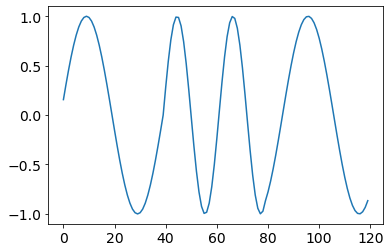

In [25]:
### This demonstrates the way to build the signal. Starting phase is arbitrary
ph = 0
# Build the first symbol
s1,ph = symbol(1200,ph)
# And continue
s2,ph = symbol(2200,ph)
s3,ph = symbol(1200,ph)

# The arrays are assembled with the np.concatenate() function as below.
plt.plot(np.concatenate([s1,s2,s3]))

Now to put an algorithm together for generating the signal from the bit stream. The original audio example starts with a 1200 Hz tone, so we initialize old_bit to the same as the first bit in the stream (0, since that is the first bit in the flag) and start with 1200 Hz.

In [26]:
bits_out = encode(chr(0x7e))*74 + done + encode(chr(0x7e))*7

f = {-1:1200, 1:2200}
t = -1
fs = 48000   # Sampling frequency
baud = 1200

ph = 0
signal,ph = symbol(f[t],ph,fs=fs,baud=baud)  # initialize array to concatenate the signal to

for b in bits_out:
    if b == '0':
        t *= -1
    next_symbol,ph = symbol(f[t],ph,fs=fs,baud=baud)
    signal = np.concatenate([signal,next_symbol])

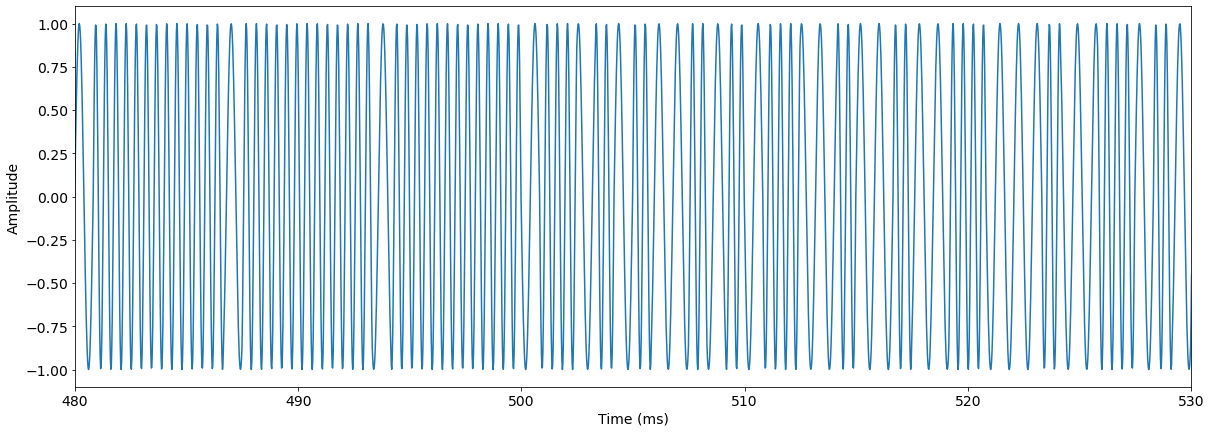

In [27]:
time = np.arange(0,len(signal)/rate,1/rate)    # Create the time base for the upsampled signal
plt.figure(figsize=(20,7))
plt.plot(time*1000,signal)
plt.xlim(480,530)
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude");

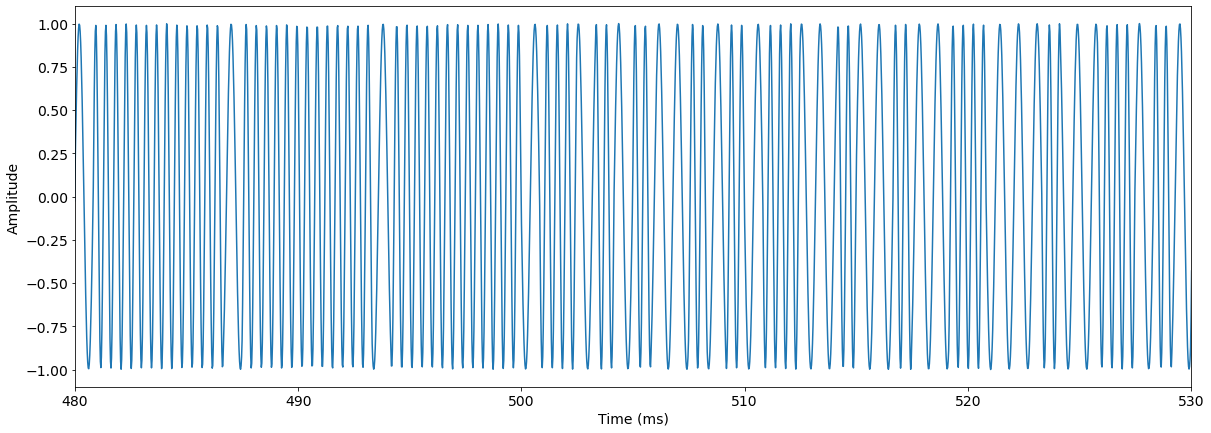

In [28]:
out_fs = 44100
out_time = np.arange(0,time[-1],1/out_fs)   # Create the time base for the output signal
out_signal = np.interp(out_time,time,signal)
plt.figure(figsize=(20,7))
plt.plot(out_time*1000,out_signal)
plt.xlim(480,530)
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude");

In [29]:
sf.write("Test_Packet.wav",out_signal,out_fs)

In [30]:
source = 'K7ARX-7'
dest = 'ZZ0ABC-3,ZZ2QRM-6'
message = 'Mary had a little lamb and said it was quite tasty.\nSome data:\n\nx,x**2,sin_x\n'
for i in range(14):
    message += "{0},{1},{2:.4f}\n".format(i,i**2,np.sin(i))
if len(message) <= 256:
    print("Message length good!")
else:
    print("Message length TOO LONG!")
data = build(source,dest,message,ssid=[0x60,0xe0],verbose=True)
f = fcs(data)
checked = data + encode(chr(f&0xff)) + encode(chr((f&0xff00)>>8))
done = encode(chr(0x7e)) + stuff(checked,verbose=True) + encode(chr(0x7e))

bits_out = encode(chr(0x7e))*74 + done + encode(chr(0x7e))*7

f = {-1:1200, 1:2200}
t = -1
fs = 48000   # Sampling frequency
baud = 1200

ph = 0
signal,ph = symbol(f[t],ph,fs=fs,baud=baud)  # initialize array to concatenate the signal to

for b in bits_out:
    if b == '0':
        t *= -1
    next_symbol,ph = symbol(f[t],ph,fs=fs,baud=baud)
    signal = np.concatenate([signal,next_symbol])

time = np.arange(0,len(signal)/fs,1/fs)    # Create the time base for the upsampled signal
out_fs = 44100
out_time = np.arange(0,time[-1],1/out_fs)   # Create the time base for the output signal
out_signal = np.interp(out_time,time[:len(signal)],signal)

sf.write("My_Packet.wav",out_signal,out_fs)

Message length good!
Source ssid: 0x6f
Dest ssid: 0xe6
Stuffing at index 129
Stuffing at index 726


In [31]:
print(message)

Mary had a little lamb and said it was quite tasty.
Some data:

x,x**2,sin_x
0,0,0.0000
1,1,0.8415
2,4,0.9093
3,9,0.1411
4,16,-0.7568
5,25,-0.9589
6,36,-0.2794
7,49,0.6570
8,64,0.9894
9,81,0.4121
10,100,-0.5440
11,121,-1.0000
12,144,-0.5366
13,169,0.4202



## Appendix A: Alternative CCITT algorithm

This version of CCITT is a better implementation if you want to calculate the checksum on the ASCII text directly rather than converting to a bit stream first.

In [32]:
ccitt_table = np.array([
    0x0000, 0x1189, 0x2312, 0x329b, 0x4624, 0x57ad, 0x6536, 0x74bf, 0x8c48, 0x9dc1, 0xaf5a, 0xbed3, 0xca6c, 0xdbe5, 0xe97e, 0xf8f7,
    0x1081, 0x0108, 0x3393, 0x221a, 0x56a5, 0x472c, 0x75b7, 0x643e, 0x9cc9, 0x8d40, 0xbfdb, 0xae52, 0xdaed, 0xcb64, 0xf9ff, 0xe876,
    0x2102, 0x308b, 0x0210, 0x1399, 0x6726, 0x76af, 0x4434, 0x55bd, 0xad4a, 0xbcc3, 0x8e58, 0x9fd1, 0xeb6e, 0xfae7, 0xc87c, 0xd9f5,
    0x3183, 0x200a, 0x1291, 0x0318, 0x77a7, 0x662e, 0x54b5, 0x453c, 0xbdcb, 0xac42, 0x9ed9, 0x8f50, 0xfbef, 0xea66, 0xd8fd, 0xc974,
    0x4204, 0x538d, 0x6116, 0x709f, 0x0420, 0x15a9, 0x2732, 0x36bb, 0xce4c, 0xdfc5, 0xed5e, 0xfcd7, 0x8868, 0x99e1, 0xab7a, 0xbaf3,
    0x5285, 0x430c, 0x7197, 0x601e, 0x14a1, 0x0528, 0x37b3, 0x263a, 0xdecd, 0xcf44, 0xfddf, 0xec56, 0x98e9, 0x8960, 0xbbfb, 0xaa72,
    0x6306, 0x728f, 0x4014, 0x519d, 0x2522, 0x34ab, 0x0630, 0x17b9, 0xef4e, 0xfec7, 0xcc5c, 0xddd5, 0xa96a, 0xb8e3, 0x8a78, 0x9bf1,
    0x7387, 0x620e, 0x5095, 0x411c, 0x35a3, 0x242a, 0x16b1, 0x0738, 0xffcf, 0xee46, 0xdcdd, 0xcd54, 0xb9eb, 0xa862, 0x9af9, 0x8b70,
    0x8408, 0x9581, 0xa71a, 0xb693, 0xc22c, 0xd3a5, 0xe13e, 0xf0b7, 0x0840, 0x19c9, 0x2b52, 0x3adb, 0x4e64, 0x5fed, 0x6d76, 0x7cff,
    0x9489, 0x8500, 0xb79b, 0xa612, 0xd2ad, 0xc324, 0xf1bf, 0xe036, 0x18c1, 0x0948, 0x3bd3, 0x2a5a, 0x5ee5, 0x4f6c, 0x7df7, 0x6c7e,
    0xa50a, 0xb483, 0x8618, 0x9791, 0xe32e, 0xf2a7, 0xc03c, 0xd1b5, 0x2942, 0x38cb, 0x0a50, 0x1bd9, 0x6f66, 0x7eef, 0x4c74, 0x5dfd,
    0xb58b, 0xa402, 0x9699, 0x8710, 0xf3af, 0xe226, 0xd0bd, 0xc134, 0x39c3, 0x284a, 0x1ad1, 0x0b58, 0x7fe7, 0x6e6e, 0x5cf5, 0x4d7c,
    0xc60c, 0xd785, 0xe51e, 0xf497, 0x8028, 0x91a1, 0xa33a, 0xb2b3, 0x4a44, 0x5bcd, 0x6956, 0x78df, 0x0c60, 0x1de9, 0x2f72, 0x3efb,
    0xd68d, 0xc704, 0xf59f, 0xe416, 0x90a9, 0x8120, 0xb3bb, 0xa232, 0x5ac5, 0x4b4c, 0x79d7, 0x685e, 0x1ce1, 0x0d68, 0x3ff3, 0x2e7a,
    0xe70e, 0xf687, 0xc41c, 0xd595, 0xa12a, 0xb0a3, 0x8238, 0x93b1, 0x6b46, 0x7acf, 0x4854, 0x59dd, 0x2d62, 0x3ceb, 0x0e70, 0x1ff9,
    0xf78f, 0xe606, 0xd49d, 0xc514, 0xb1ab, 0xa022, 0x92b9, 0x8330, 0x7bc7, 0x6a4e, 0x58d5, 0x495c, 0x3de3, 0x2c6a, 0x1ef1, 0x0f78
])

def fcs2(data):
    crc = 0xffff
    for c in data:
        crc = (crc >> 8) ^ ccitt_table[(crc ^ ord(c)) & 0xff]
    return crc ^ 0xffff

In [33]:
adata = build(source,dest,message,ssid=[0x60,0xe0],binary=False,verbose=True)  # re-build the data as ASCII rather than a binary string
hex(fcs2(adata)),hex(f)    # Demonstrate that these provide the same result

Source ssid: 0x6f
Dest ssid: 0xe6


TypeError: 'dict' object cannot be interpreted as an integer

## Appendix B: Answering Other Questions

## Appendix C: Using Different Baud Rates and Frequencies

There's no reason why AFSK can't be used at different data rates or encoding tones. The 1200/2200 Hz convention for 1200 baud AFSK is actually a comparatively poor choice. When the two encoding frequencies are spaced such that $\Delta f >> B$ for the bit rate B, the bandwidth is minimized as $2\cdot \Delta f + B$. Because 1200/2200 Hz 1200 baud definitely does *not* meet this condition, it is especially critical to maintain continous phase in the audio output. (See https://inst.eecs.berkeley.edu/~ee123/sp15/lab/lab6/Lab6-Part-A-Audio-Frequency-Shift-Keying.html). On the other hand, fidelity is improved when you have at least one cycle per bit for the lower frequency tone -- thus the minimum frequency you should use for 1200 baud is 1200 Hz. *<<Is this really true?>>*

Let's set up a different standard for 2400 baud communication. We'll use 2400 Hz as the lower tone, but try to improve the bandwidth by increasing the upper tone to 7200 Hz. Pushing up the tone frequency requires better audio sampling rates. 7200 Hz is still well below the Nyquist frequency for the standard audio sampling rate of 44.1 kHz, but distortion will increase the closer we get. Let's use a better sampling rate of 98 kHz for encoding our wav file.

Of course, sending data at this rate and frequency choice will also be limited by the quality of the system recording and processing the audio -- cheap speakers will often have poorer response at higher frequencies, for example. The best choice for higher data rates is to use regular FSK or PSK rather than AFSK.

In [52]:
source = 'K7ARX'
dest = 'TEST'
message = 'NULL'
if len(message) <= 256:
    print("Message length good!")
    print("Packing {0} bytes".format(len(message)))
else:
    print("Message length TOO LONG!")
data = build(source,dest,message,ssid=[0x60,0xe0],verbose=True)
f = fcs(data)
checked = data + encode(chr(f&0xff)) + encode(chr((f&0xff00)>>8))
done = encode(chr(0x7e)) + stuff(checked,verbose=True) + encode(chr(0x7e))

bits_out = encode(chr(0x7e))*3 + done 
parity = bits_out.count('0') % 2
if parity:
    print("Correcting Parity")
    bits_out += encode(chr(0x7e)) + encode(chr(0x7e))[1:] + encode(chr(0x7e))
else:
    bits_out += encode(chr(0x7e))*3

f = {-1:1200, 1:2200}
t = -1
fs = 48000   # Sampling frequency
baud = 8

ph = 0
signal,ph = symbol(f[t],ph,fs=fs,baud=baud)  # initialize array to concatenate the signal to

for b in bits_out:
    if b == '0':
        t *= -1
    next_symbol,ph = symbol(f[t],ph,fs=fs,baud=baud)
    signal = np.concatenate([signal,next_symbol])

time = np.arange(0,len(signal)/fs,1/fs)    # Create the time base for the upsampled signal
out_fs = 44100
out_time = np.arange(0,time[-1],1/out_fs)   # Create the time base for the output signal
out_signal = np.interp(out_time,time[:len(signal)],signal)

sf.write("My_8_Packet.wav",out_signal,out_fs)

Message length good!
Packing 4 bytes
Source ssid: 0x61
Dest ssid: 0xe0


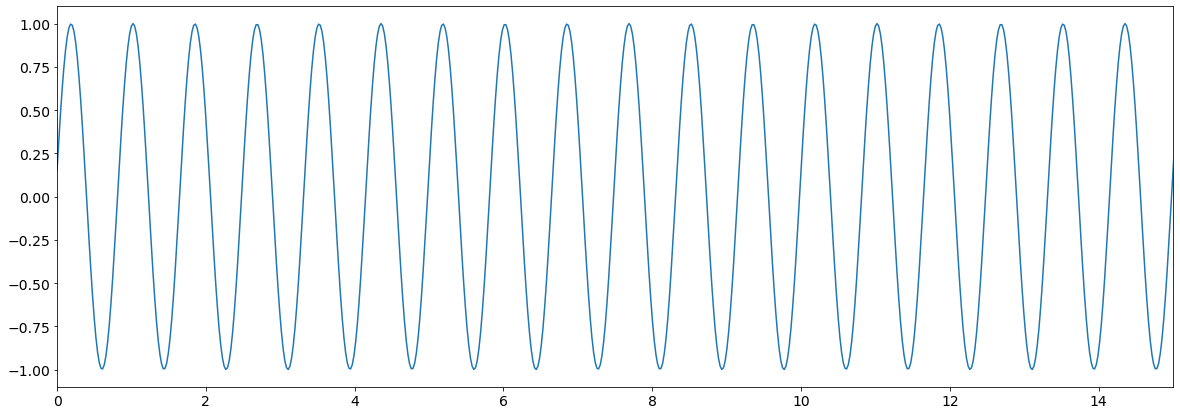

In [48]:
plt.figure(figsize=(20,7))
plt.plot(out_time*1000,out_signal)
plt.xlim(0,15);

There's still some distortion present (as evidenced by the apparent variance in amplitude), but this should do. Sadly, direwolf and other applications won't be able to verify the quality of the packet, as they're not designed to handle this custom encoding scheme. Decoding software would have to be specifically developed if the scheme were to be implemented.

In [40]:
time[-1]

114.24997916666666